In [2]:
SAVE_FOLDER = "UniDir_BIPOLAR_Vector"
SAVE_DIR = f"saliency_output/{SAVE_FOLDER}"


FOLDER = "DGIDB_BIPOLAR/"
DGIDB_DIRECTORY = "../Gen_Hypergraph/output/" + FOLDER
DGIDB_CONVERGED_VECTOR_PATH = "../Methods/output/" + FOLDER + "DGIDB_vector.npy"
MSIGDB_DIRECTORY = "../Gen_Hypergraph/output/MSigDB_FULL/"
restart_prob = 0.2  # Restart probability (theta)
num_iterations = 10  # Number of iterationsh

In [ ]:
import numpy as np
import json
from scipy.sparse import load_npz
import os
from tqdm import tqdm
# Open the JSON file and load its content into a dictionary
with open(DGIDB_DIRECTORY + "gene_to_index.json", "r") as file:
    dgidb = json.load(file)
with open(MSIGDB_DIRECTORY + "gene_to_index.json", "r") as file:
    msigdb = json.load(file)

In [ ]:
import numpy as np
# Jump probability for matching genes
w = 1

# Number of genes (assuming they are both of same size or matchable)
num_genes_dgidb = len(dgidb)
num_genes_msigdb = len(msigdb)

# Initialize the inter-layer matrix (D) with zeros
D = np.zeros((num_genes_dgidb, num_genes_msigdb))
i = 0
# Build the inter-layer matrix (D)
for gene_dgidb, idx_dgidb in dgidb.items():
    # If the gene exists in both gene-to-index mappings
    if gene_dgidb in msigdb:      
        idx_msigdb = msigdb[gene_dgidb]
        D[idx_dgidb, idx_msigdb] = w  # Set jump probability
        i += 1
rows_with_high_sum = np.where(D.sum(axis=1) > 0)[0]
# Load matrices
MSIGDB_weighted_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_weighted.npz")
MSIGDB_binary_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
DGIDB_binary_matrix = load_npz(DGIDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
DGIDB_vector =  np.load(DGIDB_CONVERGED_VECTOR_PATH)

num_genes_MSIGDB = MSIGDB_binary_matrix.shape[0]  # Number of genes in MSIGDB
# Initialize probability vectors
v0 = np.zeros(num_genes_MSIGDB)  # Combined vector for DGIDB and MSIGDB
teleport = np.zeros(num_genes_MSIGDB)  # Restart probability vector
# Initialize probability vectors
v0[:] = 1.0 / (num_genes_MSIGDB)  # Starting on DGIDB
teleport[:] = 1.0 / (num_genes_MSIGDB)


In [ ]:
import torch
from tqdm import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert sparse matrices to dense (or use PyTorch sparse support if memory limited)
MSIGDB_weighted = torch.tensor(MSIGDB_weighted_matrix.toarray(), dtype=torch.float32, device=device)
MSIGDB_binary = torch.tensor(MSIGDB_binary_matrix.toarray(), dtype=torch.float32, device=device)
DGIDB_binary = torch.tensor(DGIDB_binary_matrix.toarray(), dtype=torch.float32, device=device)
# DGIDB_vector = torch.tensor(DGIDB_vector, dtype=torch.float32, device=device)
# D = torch.tensor(D, dtype=torch.float32, device=device)

num_genes_MSIGDB = MSIGDB_binary.shape[0]
v0 = torch.full((num_genes_MSIGDB,), 1.0 / num_genes_MSIGDB, dtype=torch.float32, device=device)
teleport = v0.clone()
P = MSIGDB_weighted @ MSIGDB_weighted.T


In [ ]:

def get_hyper_randomwalk_torch(DGIDB_binary_matrix, DGIDB_vector, MSIGDB_weighted_matrix, MSIGDB_binary_matrix, D, restart_prob, num_iterations, P):
    vi = v0.clone()
    distance_list = []
    dgidb_vector_complete = np.zeros(num_genes_MSIGDB)

    for gene in tqdm(range(num_genes_MSIGDB), desc="DGIDB full vector calculation"):
        # Intra-hypergraph transitions in MSIGDB (moving within MSIGDB)
        connected_pathways = MSIGDB_binary_matrix[gene, :].nonzero()[1]  # Nonzero columns in MSIGDB binary matrix

        if len(connected_pathways) == 0:
            continue  # Skip if no pathways are found

        for pathway in connected_pathways:
            # Find genes connected to the selected pathway (weighted transition in MSIGDB)
            connected_genes = MSIGDB_weighted_matrix[:, pathway].toarray().flatten()
            neighbor_genes = np.where(connected_genes > 0)[0]  # Get genes with nonzero weight

            # Check if the current gene has a DGIDB connection
            dgidb_gene = np.where(D[:, gene] > 0)[0]  # Find DGIDB neighbors of the current MSIGDB gene
            if len(dgidb_gene) == 1:
                dgidb_drugs = DGIDB_binary_matrix[dgidb_gene[0], :].nonzero()[1]
                neighbor_genes_set = set()  # To avoid duplicates
            
                for drug in dgidb_drugs:
                    # Get genes connected through the same drug (edge)
                    connected_genes = DGIDB_binary_matrix[:, drug].toarray().flatten()
                    neighbor_genes = np.where(connected_genes > 0)[0]
                    # Add unique neighbors to the set
                    neighbor_genes_set.update(neighbor_genes)

                # Sum contributions from unique DGIDB neighbors
                if len(neighbor_genes_set) > 0:
                    neighbor_genes_list = list(neighbor_genes_set)
                    dgidb_contribution = np.sum(DGIDB_vector[neighbor_genes_list])  # Sum unique contributions
                    dgidb_vector_complete[gene] += dgidb_contribution  # Store in the complete vector

    # Normalize dgidb_vector_complete to avoid overflow
    dgidb_vector_complete /= np.sum(dgidb_vector_complete) if np.sum(dgidb_vector_complete) > 0 else 1
    dgidb_vector_complete = torch.from_numpy(dgidb_vector_complete).to(device)
    for k in range(num_iterations):
        print(f"Iteration {k + 1}")
        vj = vi.clone()

        # Vectorized transition step
        # Resulting shape will be (n, n)

        # Step 2: Normalize P by dividing by the sum of each column (with a small constant to avoid division by zero)
        P = P / (P.sum(dim=0, keepdim=True) + 1e-9)
        vi_new = torch.matmul(P.T.float(), vj.float())  # Transition from vj to vi_new using matrix multiplication

        # Normalize and combine
        vi_new = vi_new / (vi_new.sum() + 1e-9)
        
        vi = restart_prob * vi_new.T + (1 - restart_prob) * teleport + dgidb_vector_complete

        distance = torch.sum(torch.abs(vj - vi)).item()
        distance_list.append(distance)


    importance_scores = torch.argsort(vi, descending=True)
    importance_values = vi[importance_scores]

    return {
        "Importance": list(zip(importance_scores.tolist(), importance_values.tolist())),
        "Distance": distance_list
    }


In [12]:
import pandas as pd
# Save directory for saliency scores
os.makedirs(SAVE_DIR, exist_ok=True)

# Get baseline (full graph) run
result = get_hyper_randomwalk_torch(DGIDB_binary_matrix, DGIDB_vector, MSIGDB_weighted_matrix, MSIGDB_binary_matrix, D, restart_prob, num_iterations, P)

DGIDB full vector calculation: 100%|██████████| 21981/21981 [08:58<00:00, 40.81it/s] 


Iteration 1


C:\Users\richa\AppData\Local\Temp\ipykernel_31316\1789037273.py:54: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  vi = restart_prob * vi_new.T + (1 - restart_prob) * teleport + dgidb_vector_complete


Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


In [14]:

# Save baseline
df_baseline = pd.DataFrame(result["Importance"], columns=["GeneIndex", "Score"])
df_baseline.to_csv(os.path.join(SAVE_DIR, "baseline.csv"), index=False)

## Vector Perturbations

In [13]:
VECTOR_DIR = "saliency_output/DGIDB_BIPOLAR/vector"
os.makedirs(SAVE_DIR, exist_ok=True)

# Get all vector files and sort them numerically
vector_files = [f for f in os.listdir(VECTOR_DIR) if f.startswith("DGIDB_vector_") and f.endswith(".npy")]
vector_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

for vector_file in tqdm(vector_files, desc="Running saliency analysis"):
    drug_number = vector_file.split("_")[-1].split(".")[0]
    DGIDB_vector = np.load(os.path.join(VECTOR_DIR, vector_file))

    result = get_hyper_randomwalk_torch(
        DGIDB_binary_matrix,
        DGIDB_vector,
        MSIGDB_binary_matrix,
        MSIGDB_weighted_matrix,
        D,
        restart_prob,
        num_iterations,
        P
    )

    df = pd.DataFrame(result["Importance"], columns=["GeneIndex", "Score"])
    output_path = os.path.join(SAVE_DIR, f"drug_{drug_number}_saliency.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved to {output_path}")

print("✅ Done generating saliency scores for all DGIDB vectors.")

DGIDB full vector calculation: 100%|██████████| 21981/21981 [08:44<00:00, 41.88it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:   8%|▊         | 1/12 [08:54<1:37:54, 534.02s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_190_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [08:41<00:00, 42.19it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  17%|█▋        | 2/12 [17:44<1:28:38, 531.83s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_371_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [21:19<00:00, 17.18it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  25%|██▌       | 3/12 [39:11<2:11:32, 876.95s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_395_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [20:34<00:00, 17.81it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  33%|███▎      | 4/12 [59:54<2:16:10, 1021.31s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_559_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [11:36:01<00:00,  1.90s/it]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  42%|████▏     | 5/12 [12:36:08<30:33:38, 15716.87s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_717_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [13:30<00:00, 27.12it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  50%|█████     | 6/12 [12:49:47<17:45:10, 10651.79s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_843_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [20:17<00:00, 18.06it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  58%|█████▊    | 7/12 [13:10:13<10:30:51, 7570.36s/it] 

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_1030_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [18:36<00:00, 19.68it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  67%|██████▋   | 8/12 [13:28:59<6:07:54, 5518.67s/it] 

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_1438_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [18:33<00:00, 19.73it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  75%|███████▌  | 9/12 [13:47:44<3:27:14, 4144.97s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_1458_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [2:18:07<00:00,  2.65it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  83%|████████▎ | 10/12 [16:06:00<3:00:53, 5426.72s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_1733_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [09:06<00:00, 40.22it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis:  92%|█████████▏| 11/12 [16:15:15<1:05:35, 3935.51s/it]

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_2165_saliency.csv


DGIDB full vector calculation: 100%|██████████| 21981/21981 [09:08<00:00, 40.04it/s]


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


Running saliency analysis: 100%|██████████| 12/12 [16:24:32<00:00, 4922.70s/it]  

Saved to saliency_output/UniDir_BIPOLAR_Vector\drug_2915_saliency.csv
✅ Done generating saliency scores for all DGIDB vectors.


## Pathway Perturbation

In [ ]:
# # Perturb each pathway (remove one hyperedge at a time)
# from tqdm import tqdm

# # Set random seed for reproducibility (optional)
# np.random.seed(42)

# # Choose 25 unique random pathway indices
# all_pathways = np.arange(MSIGDB_binary_matrix.shape[1])
# selected_pathways = np.random.choice(all_pathways, size=25, replace=False)

# skipped = []
# for pathway_idx in tqdm(selected_pathways, desc="Running saliency analysis on 25 random pathways"):
#     # Skip pathway if it has no connections
#     if MSIGDB_binary_matrix[:, pathway_idx].nnz == 0:
#         skipped.append(pathway_idx)
#         continue

#     # Make copies to modify
#     binary_copy = MSIGDB_binary_matrix.copy().tolil()
#     weighted_copy = MSIGDB_weighted_matrix.copy().tolil()

#     # Zero out the pathway column (remove the hyperedge)
#     binary_copy[:, pathway_idx] = 0
#     weighted_copy[:, pathway_idx] = 0

#     # Convert back to csr for efficiency
#     binary_csr = binary_copy.tocsr()
#     weighted_csr = weighted_copy.tocsr()

#     # Run random walk on the perturbed graph
#     result = get_hyper_randomwalk_torch(DGIDB_binary_matrix, DGIDB_vector, binary_csr, weighted_csr, D, restart_prob, num_iterations, P)

#     # Save to CSV
#     df = pd.DataFrame(result["Importance"], columns=["GeneIndex", "Score"])
#     df.to_csv(os.path.join(SAVE_DIR, f"saliency_pathway_{pathway_idx}.csv"), index=False)
#     print(f"Saved to saliency_pathway_{pathway_idx}.csv")


# # Optionally print or save skipped pathway
# print(f"Skipped {len(skipped)} pathway(s) with no connections: {skipped}")

# print("✅ Done generating saliency scores.")

In [5]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
with open(MSIGDB_DIRECTORY + "gene_to_index.json", "r") as file:
    gene_to_index = json.load(file)

# with open(MSIGDB_DIRECTORY + "pathway_to_index.json", "r") as file:
#     pathway_to_index = json.load(file)
with open(DGIDB_DIRECTORY + "drug_to_index.json", "r") as file:
    drug_to_index = json.load(file)
# Path to folder containing saliency CSVs
SAL_DIR = "saliency_output/UniDir_BIPOLAR_Vector/"

# Load baseline
baseline_df = pd.read_csv(os.path.join(SAL_DIR, "baseline.csv"))
baseline_scores = baseline_df.set_index("GeneIndex")["Score"]
# Initialize storage
saliency_matrix = []
drug_indices = []

# Regex pattern to extract drug index
pattern = re.compile(r"drug_(\d+)_saliency\.csv")

# List all saliency CSV files except baseline
csv_files = [f for f in os.listdir(SAL_DIR) if pattern.match(f)]

for fname in tqdm(sorted(csv_files, key=lambda f: int(pattern.match(f).group(1)))):
    drug_idx = int(pattern.match(fname).group(1))
    fpath = os.path.join(SAL_DIR, fname)

    perturbed_df = pd.read_csv(fpath)
    perturbed_scores = perturbed_df.set_index("GeneIndex")["Score"]

    # Align with baseline and compute saliency
    aligned = baseline_scores.subtract(perturbed_scores, fill_value=0)
    saliency_matrix.append(aligned.values)
    drug_indices.append(drug_idx)

# Create DataFrame: rows = drugs, cols = genes
saliency_df = pd.DataFrame(saliency_matrix, index=drug_indices, columns=baseline_scores.index)
# Invert the drug_to_index dictionary: index -> drug name
index_to_drug = {idx: drug for drug, idx in drug_to_index.items()}

# Rename rows (drug indices) to drug names
saliency_df.index = saliency_df.index.map(index_to_drug)

# Now the rows show drug names instead of indices
print(saliency_df.head())



100%|██████████| 12/12 [00:00<00:00, 127.23it/s]


GeneIndex       17056     17461         17490         5636          13094  \
RISPERIDONE  0.000126 -0.000348  3.692912e-08  8.417192e-08 -7.520066e-08   
CLOZAPINE    0.000214 -0.000006  1.557055e-09  2.024535e-07  7.410563e-08   
LITHIUM      0.000017 -0.000307 -4.944377e-08  6.291521e-08  1.500375e-07   
ALLOPURINOL  0.000007 -0.000274  1.852459e-08 -7.039489e-09 -6.027039e-08   
OLANZAPINE   0.000191 -0.000309 -2.442903e-08  8.830102e-08 -9.400537e-09   

GeneIndex           4555          9127          3023          17513  \
RISPERIDONE  8.295683e-08 -2.152665e-07 -2.510205e-08 -2.328416e-07   
CLOZAPINE    8.568895e-08 -3.749010e-07 -1.724984e-07 -2.718734e-07   
LITHIUM      1.350782e-07 -1.468470e-07  1.120497e-09  4.328103e-08   
ALLOPURINOL -1.517037e-08 -1.154585e-07  1.750959e-08 -1.923399e-08   
OLANZAPINE   2.343950e-07 -5.272886e-08 -7.858034e-08 -1.705521e-07   

GeneIndex           15885  ...         15828         16986         16987  \
RISPERIDONE -1.961234e-08  ...  6.

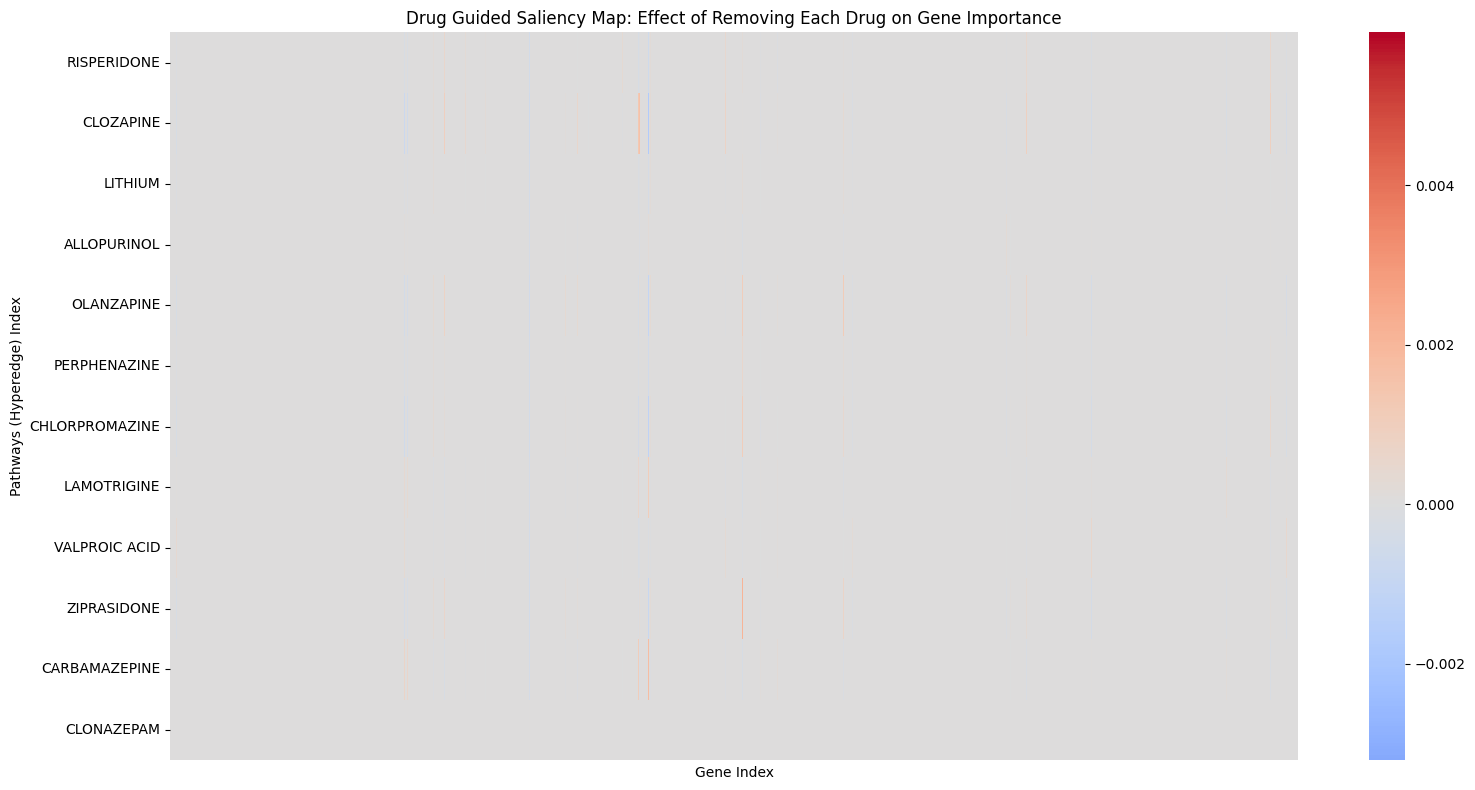

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(saliency_df, cmap="coolwarm", center=0, xticklabels=False)
plt.xlabel("Gene Index")
plt.ylabel("Pathways (Hyperedge) Index")
plt.title("Drug Guided Saliency Map: Effect of Removing Each Drug on Gene Importance")
plt.tight_layout()
plt.show()
